In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
lmaps = os.listdir('cmaps')
maps = []
for i in lmaps:
    max_size = 408
    im_reshape = np.zeros((max_size, max_size))
    im = np.asarray(Image.open(os.path.join('cmaps', i)))
    im_correct = im[im.any(axis=1)][:, im.any(axis=0)]
    n, p = im_correct.shape
    # The data is rescalde between 0 and 1
    im_rescale = - (im_correct / 255) + 1
    # Center and reshape the data
    im_rescale = np.pad(im_rescale, [((max_size - n) // 2, (max_size - n) - (max_size - n) // 2), ((max_size - p) // 2, (max_size - p) - (max_size - p) // 2)])
    maps.append(im_rescale[:,:].astype(np.float32)) 

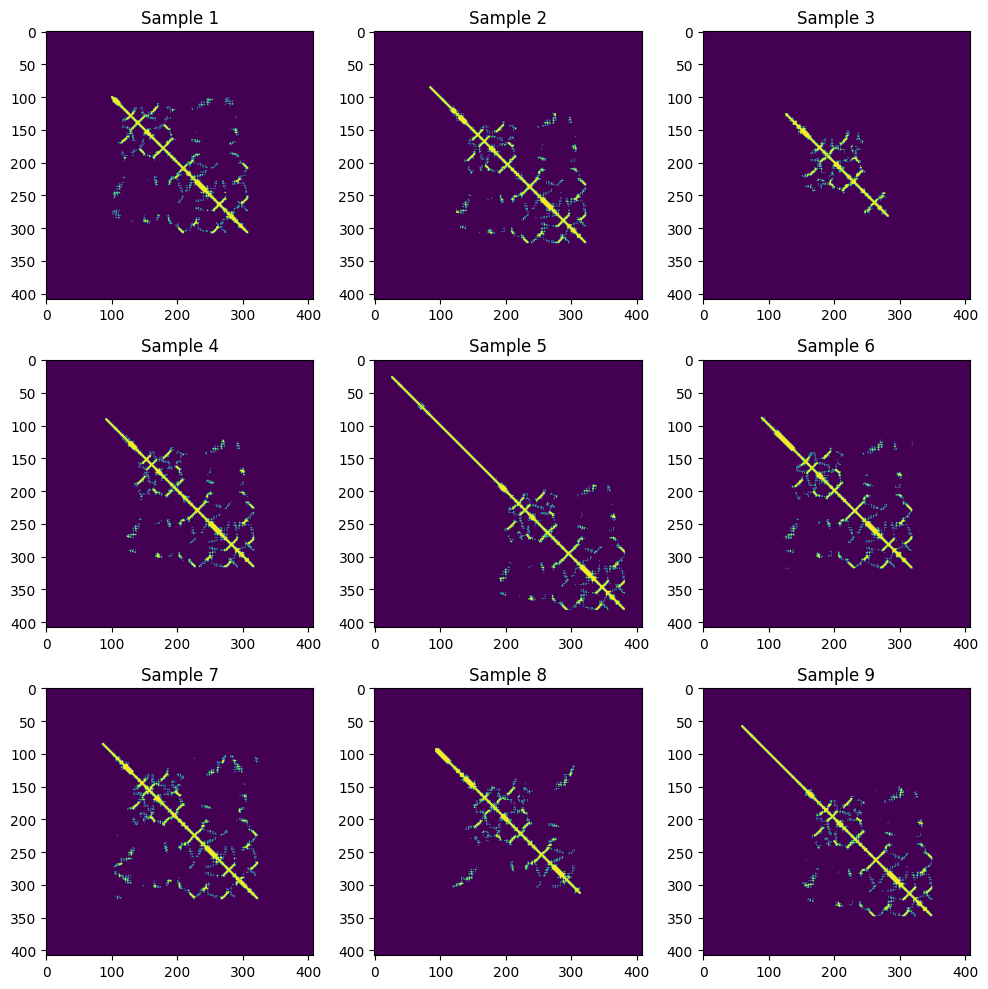

In [6]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
for idx,i in enumerate(np.random.choice(len(maps), 9)):
    ax[idx // 3, idx % 3].imshow(maps[i])
    ax[idx // 3, idx % 3].set_title(f"Sample {idx+1}") 
plt.tight_layout()
plt.show()  

In [32]:
import pandas as pd
data = pd.read_csv('InterPro_output_forannotation_new.csv', delimiter = ";")
cmaps = np.array([map.removesuffix('_origin.png') for map in lmaps])
data['acno'] = pd.Categorical(data['acno'], categories=cmaps, ordered=True)
data = data.sort_values('acno').dropna().reset_index(drop=True)
domains = data.values
domain_names = pd.get_dummies(data, columns=['domain']).columns[3:10].values
domain_names = [domain.replace('domain_','') for domain in domain_names]

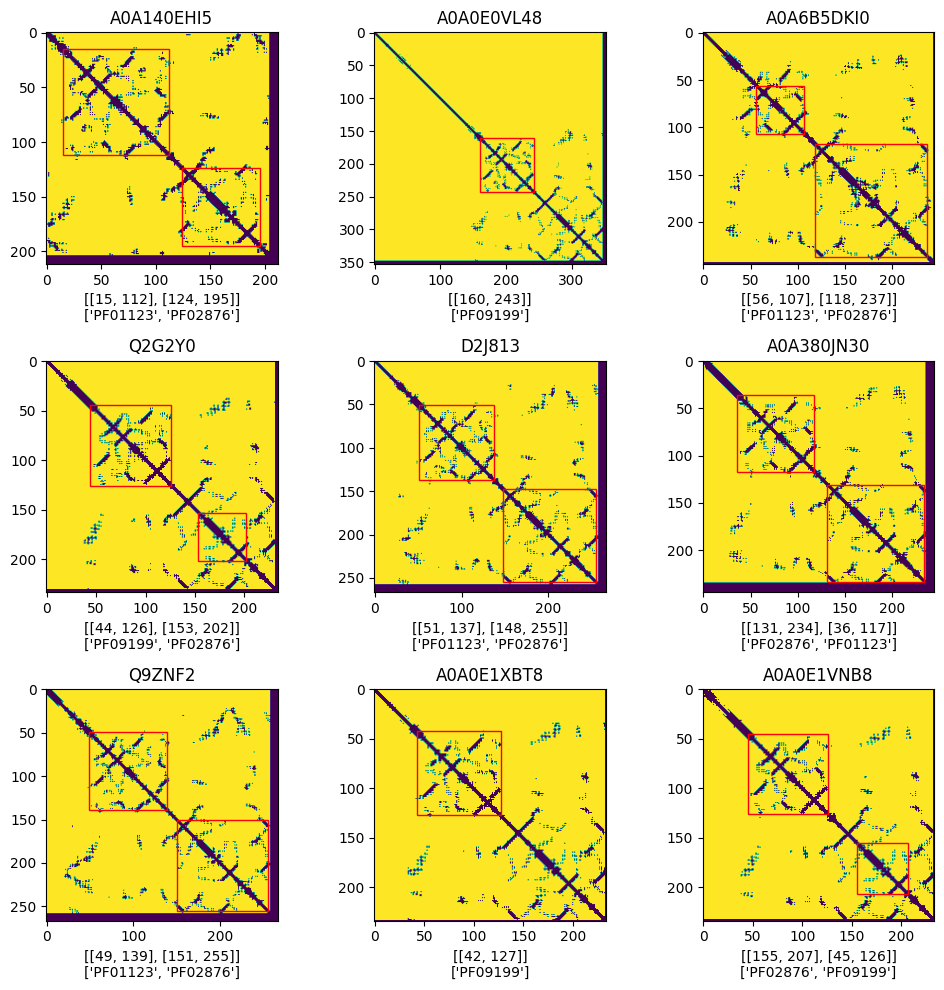

In [27]:
import ast
fig, ax = plt.subplots(3,3, figsize=(10,10))
for idx, j in enumerate(np.random.choice(len(domains), 9)):
    name, regions = domains[j,0], ast.literal_eval(domains[j,2])
    ax[idx // 3, idx % 3].imshow(np.asarray(Image.open(os.path.join('cmaps', lmaps[j]))))
    ax[idx // 3, idx % 3].set_title(name)
    for i in regions:
        ax[idx // 3, idx % 3].add_patch(Rectangle((i[0], i[0]),
                                                  i[1] - i[0],
                                                  i[1] - i[0],
                                                  fc = 'none',
                                                  ec = 'red'
                                                  )
                                        )
        ax[idx // 3, idx % 3].set_xlabel(str(regions)+'\n'+ domains[j,1])
plt.tight_layout()
plt.show()

In [24]:
domains_sort = [np.concatenate([np.array([domain[0]]).repeat(len(np.array(ast.literal_eval(domain[1]))))[:,None], np.array(ast.literal_eval(domain[1]))[:,None], np.array(ast.literal_eval(domain[2]))], axis = 1) for domain in domains]
domains_sort[:5]

[array([['A0A068A244', 'PF02876', '147', '254'],
        ['A0A068A244', 'PF01123', '49', '137']], dtype='<U11'),
 array([['A0A075M4C7', 'PF01123', '78', '166'],
        ['A0A075M4C7', 'PF02876', '176', '283']], dtype='<U11'),
 array([['A0A076KXB2', 'PF01123', '24', '101']], dtype='<U11'),
 array([['A0A077UHQ7', 'PF01123', '51', '133'],
        ['A0A077UHQ7', 'PF02876', '143', '248']], dtype='<U11'),
 array([['A0A077UK19', 'PF02876', '168', '258'],
        ['A0A077UK19', 'PF01123', '41', '137']], dtype='<U11')]

In [25]:
domains_sort = [i[i[:,2].astype(int).argsort()] for i in domains_sort]
domains_sort[:5]

[array([['A0A068A244', 'PF01123', '49', '137'],
        ['A0A068A244', 'PF02876', '147', '254']], dtype='<U11'),
 array([['A0A075M4C7', 'PF01123', '78', '166'],
        ['A0A075M4C7', 'PF02876', '176', '283']], dtype='<U11'),
 array([['A0A076KXB2', 'PF01123', '24', '101']], dtype='<U11'),
 array([['A0A077UHQ7', 'PF01123', '51', '133'],
        ['A0A077UHQ7', 'PF02876', '143', '248']], dtype='<U11'),
 array([['A0A077UK19', 'PF01123', '41', '137'],
        ['A0A077UK19', 'PF02876', '168', '258']], dtype='<U11')]

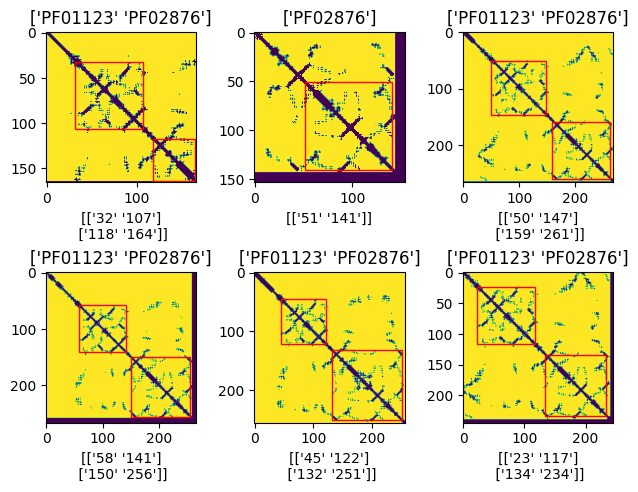

In [28]:
fig, ax = plt.subplots(2,3)
for idx, j in enumerate(np.random.choice(len(domains), 6)):
    name, regions = domains_sort[j][:,1], domains_sort[j][:,2:]
    ax[idx // 3, idx % 3].imshow(np.asarray(Image.open(os.path.join('cmaps', lmaps[j]))))
    ax[idx // 3, idx % 3].set_title(str(name))
    for k in regions:
        i = k.astype(int)
        ax[idx // 3, idx % 3].add_patch(Rectangle((i[0], i[0]),
                                                  i[1] - i[0],
                                                  i[1] - i[0],
                                                  fc = 'none',
                                                  ec = 'red'
                                                  )
                                        )
        ax[idx // 3, idx % 3].set_xlabel(str(regions))
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

In [29]:
df = pd.DataFrame(np.concatenate(domains_sort, axis = 0), columns = ['Name', 'Domain', 'Start', 'End'])
df_tf = df.groupby("Name").transform(lambda x: ','.join(x))
df_tf["Name"] = df["Name"]
df_final = df_tf.drop_duplicates().reset_index(drop = True)
df_final.filter(["Name", "Domain"]).to_csv('filtered_labels.csv', index = False)